<a href="https://colab.research.google.com/github/krishnamohanathota/GenerativeAI/blob/main/vector-dbs/pinecone/vectordbs_pinecone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pinecone

Long-Term Memory for AI

In [1]:
!pip install openai
!pip install python-dotenv
!pip install pinecone-client

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd gdrive/MyDrive/ColabEnv/env/

/content/gdrive/MyDrive/ColabEnv/env


In [4]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

# Specify the path to the .env file in your Google Drive "ColabEnv" folder
#env_file_path = '/content/gdrive/My Drive/ColabEnv/.env'

# Load the environment variables from the .env file
#load_dotenv(env_file_path)

_ = load_dotenv(find_dotenv()) # Load a local .env file

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
PINECONE_ENV = os.environ['PINECONE_ENV']

openai.api_key = OPENAI_API_KEY


## Index

An index is the highest-level organizational unit of vector data in Pinecone. It accepts and stores vectors, serves queries over the vectors it contains, and does other vector operations over its contents.

Each record in a Pinecone index contains a unique ID and an array of floats representing a dense vector embedding.

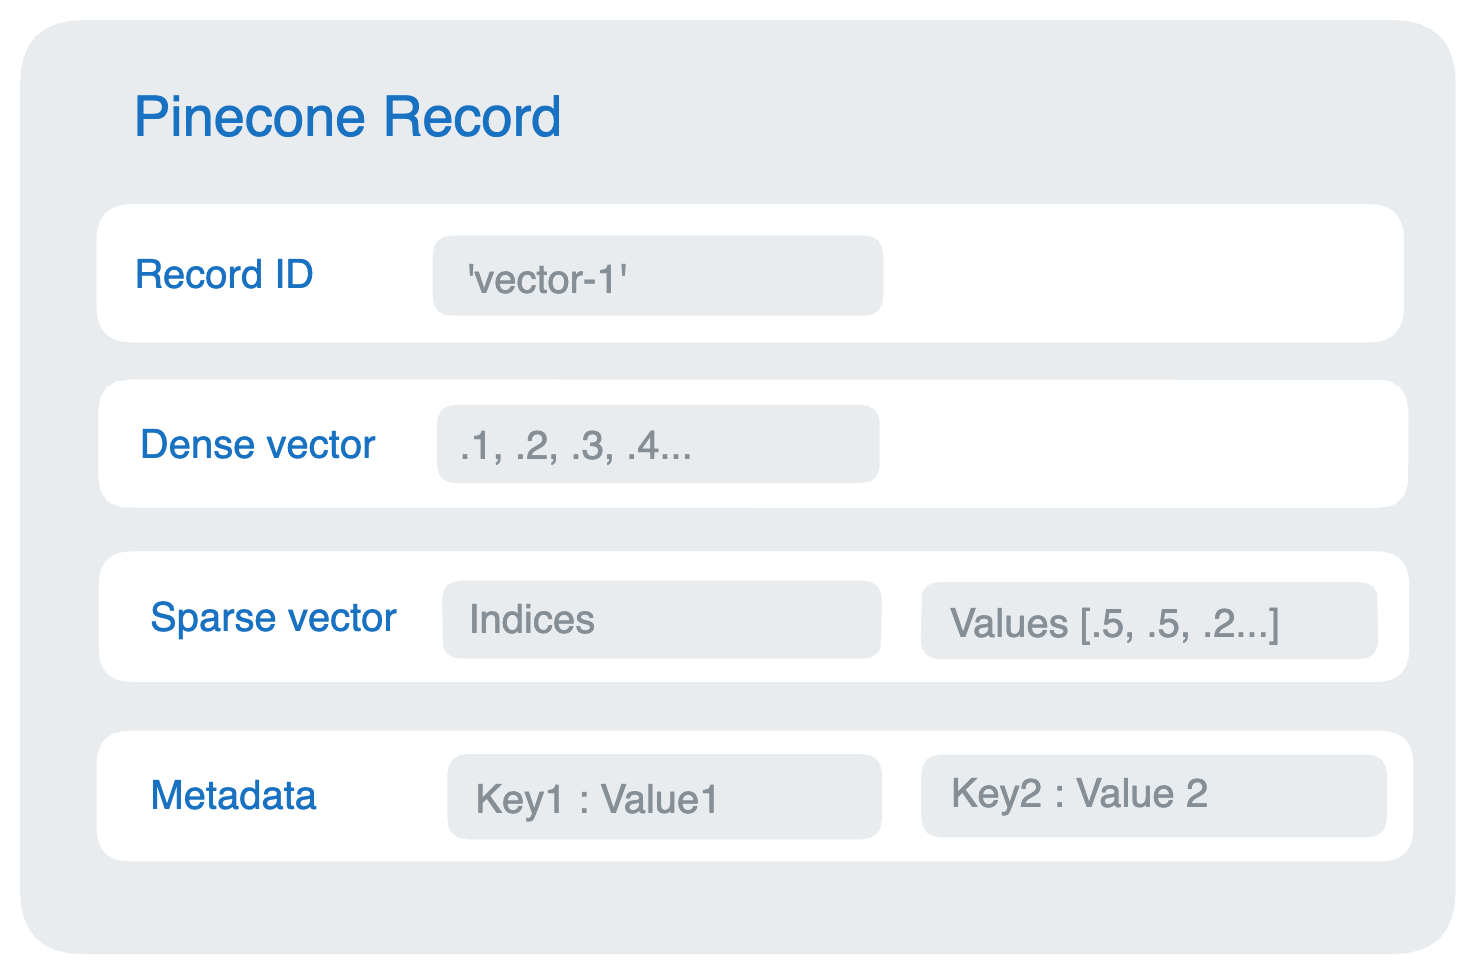

In [5]:
import pinecone

# https://docs.pinecone.io/docs/quickstart
pinecone.init(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

# PineCone Index
PINECONE_TABLE_NAME = "test-aug-01"

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
# https://docs.pinecone.io/reference/create_index

# When using a starter plan, all create_index calls ignore the "pod_type" parameter
# Distance Metrics : https://docs.pinecone.io/docs/indexes#distance-metrics

def create_pinecone_index(table_name, dimensions = 1536, metric="cosine", pod_type="p1"):
  if table_name not in pinecone.list_indexes():
    print("# Creating Index..")
    pinecone.create_index(name=table_name, dimension=dimensions, metric=metric, pod_type=pod_type)

# https://platform.openai.com/docs/guides/embeddings/use-cases
def get_embedding(text):
  print("# Get Embeddings for given text..")
  text = text.replace("\n", " ")
  return openai.Embedding.create(input=text, model="text-embedding-ada-002")["data"][0]["embedding"]

def upsert_to_index(index, texts):
    """
      # https://docs.pinecone.io/reference/upsert
      # https://docs.pinecone.io/docs/python-client#upsert-vectors
    """
    print("# Upsert data to index..")
    pinecone_vectors = []

    """
    Each Vector structure
    (
         "vec1",                # Vector ID
         [0.1, 0.2, 0.3, 0.4],  # Dense vector values
         {"genre": "drama"}     # Vector metadata
    )
    """
    for loopIndex, text in enumerate(texts, start=1):
        pinecone_vectors.append(("test-openai-"+str(loopIndex), get_embedding(text), {"text": text}))

    #print(pinecone_vectors)

    index.upsert(vectors=pinecone_vectors)


# https://docs.pinecone.io/docs/python-client#indexquery
def query_index(index, text, top_k=3):
  print("# Query Index..")
  q_embedding = get_embedding(text)
  pineQ = index.query(q_embedding, top_k=top_k, include_values=False, include_metadata=True)
  return pineQ

def print_results(pineQ):
    # Prints the value of pineQ with cyan color (ANSI escape code for cyan is \033[36m).
    # The \033[0m at the end is an ANSI escape code to reset the color back to the default.
    print(f"\033[36m" + str(pineQ) + "\033[0m")
    print("\n")
    for match in pineQ.matches:
        # Prints each match item with green color (ANSI escape code for green is \033[32m) and bold font (ANSI escape code for bold is \033[1m).
        print(f"\033[1m\033[32m" + match.metadata['text'] + " (" + str(round(match.score*100,2)) + "%)" + "\033[0m")



In [12]:
def main():
  create_pinecone_index(PINECONE_TABLE_NAME)

  print(pinecone.list_indexes())

  #Connect to the index (Client only)
  index = pinecone.Index(PINECONE_TABLE_NAME)

  """
  texts = [
        "AI Agents as virtual employees are the future",
        "Vector Databases are the future",
        "AGI is not here....yet."
  ]

  upsert_to_index(index, texts)

  # print(index.describe_index_stats())
  """

  query_text = "are vector dbs the future?"
  results = query_index(index, query_text)
  print_results(results)


In [13]:
main()

['test-aug-01']
# Query Index..
# Get Embeddings for given text..
{'matches': [{'id': 'test-openai-2',
              'metadata': {'text': 'Vector Databases are the future'},
              'score': 0.917177558,
              'values': []},
             {'id': 'test-openai-1',
              'metadata': {'text': 'AI Agents as virtual employees are the '
                                   'future'},
              'score': 0.774561822,
              'values': []},
             {'id': 'test-openai-3',
              'metadata': {'text': 'AGI is not here....yet.'},
              'score': 0.712451935,
              'values': []}],
 'namespace': ''}


Vector Databases are the future (91.72%)
AI Agents as virtual employees are the future (77.46%)
AGI is not here....yet. (71.25%)


In [15]:
#Connect to the index (Client only)
index = pinecone.Index(PINECONE_TABLE_NAME)

print(index.describe_index_stats())

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 3}},
 'total_vector_count': 3}


In [18]:
#Connect to the index (Client only)
index = pinecone.Index(PINECONE_TABLE_NAME)

# Fetch a specific vector from the Pinecone index.
def fetch_vector(index, vectorId):
  return index.fetch(ids=[vectorId])

print(fetch_vector(index, 'test-openai-1'))

{'namespace': '',
 'vectors': {'test-openai-1': {'id': 'test-openai-1',
                               'metadata': {'text': 'AI Agents as virtual '
                                                    'employees are the future'},
                               'values': [-0.0267617032,
                                          -0.020734055,
                                          -0.0135193421,
                                          -0.0136908069,
                                          0.00625187159,
                                          0.0288588498,
                                          -0.0295183305,
                                          0.00357438228,
                                          -0.00180038076,
                                          -0.0336598642,
                                          0.0104725445,
                                          0.0344776213,
                                          -0.00426024152,
                                